# Bi-LSTM Model

In [2]:
# imports
import pandas as pd
from nltk import word_tokenize
from gensim.models import Word2Vec

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

/var/folders/sh/9y2x7hyx76bghklsygtm6m000000gn/T/ipykernel_44069/889822392.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
# Reading in the data from our two files
google_df = pd.read_csv('processed_google_data.csv')
tweets_df = pd.read_csv('processed_cyberbullying_tweets.csv')

google_df.head()

,cyberbullying_type,processed_tweet_text
0,0,game hurt
1,0,right care fuck
2,0,man love reddit
3,0,name nowhere near falcon
4,0,right considering ’ important document know da...


In [4]:
tweets_df.head()

,cyberbullying_type,processed_tweet_text
0,0,words katandandre food crapilicious mkr
1,0,aussietv white mkr theblock imacelebrityau tod...
2,0,xochitlsuckks classy whore red velvet cupcakes
3,0,meh p thanks heads concerned another angry dud...
4,0,rudhoeenglish isis account pretending kurdish ...


In [5]:
# Creating a combined dataframe of the two datasets
combined_df = pd.concat([tweets_df, google_df], ignore_index=True)

# Putting the combined dataframe into a csv file
FILE = 'processed_concat_data.csv'
combined_df.to_csv(FILE, index=False)

In [6]:
# Load the data
concat_df = pd.read_csv(FILE)

# Take the text of the data and convert it to a list
tweets = concat_df['processed_tweet_text'].astype(str).tolist()

# Tokenize the sentences
tokenized_sentences = [word_tokenize(sentence.lower()) for sentence in tweets]
model_w2v = Word2Vec(sentences=tokenized_sentences, vector_size=100, window=5, min_count=1, workers=4)

model_w2v.wv['food']

vocab_size = len(model_w2v.wv.key_to_index)
vocab_size

# Create a new column in the dataframe to store the word embeddings
concat_df['word_embeddings'] = concat_df.apply(lambda x : list(), axis=1)

# For each row in the dataframe, get the word embeddings for each word in the tweet
for index, row in concat_df.iterrows():
    for word in word_tokenize(str(row['processed_tweet_text']).lower()):
        row['word_embeddings'].append(model_w2v.wv[word])
    while len(row['word_embeddings']) < 50:
        row['word_embeddings'].append([0]*100)
    
# Check the first row to see if the word embeddings have been added
len(concat_df.loc[0, 'word_embeddings'])
len(concat_df.loc[0, 'word_embeddings'][0])

model_w2v.wv['words']

# Split the data based on Cyberbullying type, where 0 is not cyberbullying and 1 is cyberbullying
X = concat_df['word_embeddings'].tolist()
y = concat_df['cyberbullying_type'].tolist()

data_0 = concat_df[concat_df['cyberbullying_type'] == 0]
print(data_0.shape)
data_1 = concat_df[concat_df['cyberbullying_type'] == 1]
print(data_1.shape)


(191084, 3)
(64422, 3)


In [7]:
# Sample the data to balance the classes as desired and create a new DataFrame
sampled_data_0 = data_0.sample(n=56000, random_state=42)
sampled_data_1 = data_1.sample(n=64000, random_state=42)

balanced_df = pd.concat([sampled_data_0, sampled_data_1])

X_dec = balanced_df['word_embeddings'].tolist()
y_dec = balanced_df['cyberbullying_type'].tolist()

# Shuffle the resulting DataFrame to mix the examples of 0s and 1s
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_dec, y_dec, test_size=0.3, random_state=42)

In [8]:
# Padding sequences to ensure uniform input size
max_length = max(max(len(seq) for seq in X_train), max(len(seq) for seq in X_test))
X_train_padded = pad_sequences(X_train, maxlen=max_length, padding='post', dtype='float32')
X_test_padded = pad_sequences(X_test, maxlen=max_length, padding='post', dtype='float32')

# Metrics callback to calculate precision, recall and F1 score during the model training
class MetricsCallback(tf.keras.callbacks.Callback):
    
    # Initialize the callback with the test data
    def __init__(self, X_test, y_test):
        self.X_test = X_test
        self.y_test = y_test
        self.precision_scores = []
        self.recall_scores = []
        self.f1_scores = []

    # Calculate precision, recall and F1 score at the end of each epoch
    def on_epoch_end(self, epoch, logs=None):
        y_pred = self.model.predict(self.X_test)
        y_pred = np.round(y_pred)
        precision = precision_score(self.y_test, y_pred)
        recall = recall_score(self.y_test, y_pred)
        f1 = f1_score(self.y_test, y_pred)
        self.precision_scores.append(precision)
        self.recall_scores.append(recall)
        self.f1_scores.append(f1)
        print(f"Epoch {epoch}: Precision={precision}, Recall={recall}, F1={f1}")

In [15]:
# Create new instance of the MetricsCallback class
metrics_callback = MetricsCallback(X_test_padded, y_test)

# Building the model architecture with Bidirectional LSTM
model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(max_length, 100)))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(1, activation='sigmoid'))  # Use 'softmax' for multi-class classification

# Compiling the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # Use 'categorical_crossentropy' for multi-class classification

# Training the model
history = model.fit(X_train_padded, np.array(y_train), epochs=10, batch_size=64, validation_split=0.2, callbacks=[metrics_callback])

# Evaluating the model
loss, accuracy = model.evaluate(X_test_padded, np.array(y_test))
print(f'Test Accuracy: {accuracy}')

Epoch 1/10
1125/1125 [==============================] - 75s 66ms/step
Epoch 0: Precision=0.864638783269962, Recall=0.7145326001571092, F1=0.7824516129032258
1050/1050 [==============================] - 496s 470ms/step - loss: 0.4486 - accuracy: 0.7726 - val_loss: 0.4315 - val_accuracy: 0.7835
Epoch 2/10
1125/1125 [==============================] - 72s 64ms/step
Epoch 1: Precision=0.869851525128906, Recall=0.7332809636030374, F1=0.7957490338713344
1050/1050 [==============================] - 495s 472ms/step - loss: 0.4114 - accuracy: 0.7966 - val_loss: 0.4146 - val_accuracy: 0.7924
Epoch 3/10
1125/1125 [==============================] - 72s 64ms/step
Epoch 2: Precision=0.8228019742908282, Recall=0.7944488085886358, F1=0.8083768517531706
1050/1050 [==============================] - 492s 469ms/step - loss: 0.3968 - accuracy: 0.8067 - val_loss: 0.4121 - val_accuracy: 0.7987
Epoch 4/10
1125/1125 [==============================] - 73s 65ms/step
Epoch 3: Precision=0.8557567151816353, Recall=0

In [46]:
# Manually predicting the sentiment of a given sentence
def predict_sentiment(sentence, model, word2vec_model):
    # Tokenize and convert to embeddings
    tokens = word_tokenize(sentence.lower())
    print(tokens)
    embeddings = [word2vec_model.wv[token] if token in word2vec_model.wv else np.zeros(100) for token in tokens]
    
    # Pad the sequence
    padded_embeddings = pad_sequences([embeddings], maxlen=max_length, padding='post', dtype='float32')
    print(padded_embeddings)
    # Predict
    prediction = model.predict(padded_embeddings)
    print(prediction)
    # Assuming binary classification with a sigmoid output layer
    predicted_label = 'Positive' if prediction[0][0] < 0.50 else 'Negative'
    
    return predicted_label, prediction[0][0]

['you', 'are', 'so', 'fricking', 'cool']
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
1/1 [==============================] - 0s 48ms/step
[[0.2213641]]
Sentence: 'you are so fricking cool'
Predicted Sentiment: Positive (Confidence: 0.22)


In [ ]:
# Example usage of the predict_sentiment function
test_sentence = "you are so fricking cool"

predicted_label, confidence = predict_sentiment(test_sentence, model, model_w2v)

print(f"Sentence: '{test_sentence}'")
print(f"Predicted Sentiment: {predicted_label} (Confidence: {confidence:.2f})")

1125/1125 [==============================] - 72s 64ms/step
              precision    recall  f1-score   support

           0       0.78      0.80      0.79     16905
           1       0.82      0.80      0.81     19095

    accuracy                           0.80     36000
   macro avg       0.80      0.80      0.80     36000
weighted avg       0.80      0.80      0.80     36000



<Axes: >

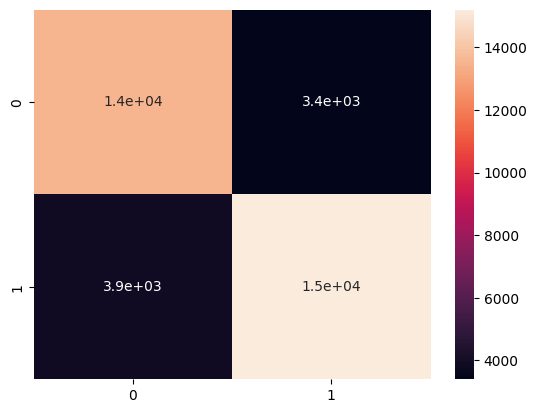

In [47]:
# Creating a confusion matrix and classification report for the model with the test data
y_pred = model.predict(X_test_padded)
y_pred = (y_pred > 0.5)
y_pred = y_pred.astype(int)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)

[0.864638783269962, 0.869851525128906, 0.8228019742908282, 0.8557567151816353, 0.8540644709180099, 0.8357442055291818, 0.8706805304775543, 0.848463768115942, 0.8127017729558084, 0.817355771815689]
[0.7145326001571092, 0.7332809636030374, 0.7944488085886358, 0.7574757789997382, 0.7659073055773763, 0.7836606441476827, 0.7323383084577114, 0.766483372610631, 0.8041895784236711, 0.7961246399581042]
[0.7824516129032258, 0.7957490338713344, 0.8083768517531706, 0.8036225240992305, 0.807587178000497, 0.8088648648648649, 0.795539879394698, 0.8053927637914431, 0.8084232692813899, 0.8066005199766542]
[0.7835118770599365, 0.7924404740333557, 0.7987499833106995, 0.7989881038665771, 0.8033333420753479, 0.7965475916862488, 0.7952976226806641, 0.7980952262878418, 0.7912499904632568, 0.7925595045089722]
10 10 10 10 10


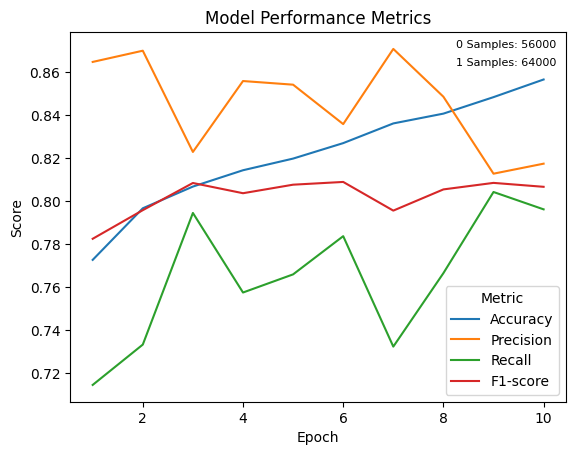

In [17]:
# Defining the metrics to plot
epochs = range(1, len(history.history['loss']) + 1)
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
precision = metrics_callback.precision_scores
recall = metrics_callback.recall_scores
f1 = metrics_callback.f1_scores

# Printing the metrics for debugging purposes
print(precision)
print(recall)
print(f1)
print(val_accuracy)
print(len(epochs), len(accuracy), len(precision), len(recall), len(f1))

# Plotting the model performance metrics
data = pd.DataFrame({'Epoch': epochs, 'Accuracy': accuracy, 'Precision': precision, 
                     'Recall': recall, 'F1-score': f1})
data = pd.melt(data, id_vars=['Epoch'], var_name='Metric', value_name='Score')

sns.lineplot(x='Epoch', y='Score', hue='Metric', data=data)
plt.title('Model Performance Metrics')

plt.text(0.98, 0.98, f'0 Samples: {56000}', 
         horizontalalignment='right', verticalalignment='top', transform=plt.gca().transAxes, fontsize=8)
plt.text(0.98, 0.93, f'1 Samples: {64000}', 
         horizontalalignment='right', verticalalignment='top', transform=plt.gca().transAxes, fontsize=8)

plt.show()

In [ ]:
# Saving the model, this can be loaded later to make predictions, though the naming convention should be changed based on the model
model.save('cyberbullying_detection_model_epoch10.h5')

# Saving Word2Vec model and embeddings
model_w2v.save('word2vec_model.model')
model_w2v.wv.save_word2vec_format('word2vec_embeddings.txt', binary=False)